In [13]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# !pip install pennylane custatevec-cu11 pennylane-lightning-kokkos

import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1701156576.3618758
Tue Nov 28 07:29:36 2023


In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def create_data_point(n):
    """
    Returns a random undirected adjacency matrix of dimension (n,n).
    The diagonal elements are interpreted as node attributes.
    """
    mat = np.random.rand(n, n)
    A = (mat + np.transpose(mat))/2
    return np.round(A, decimals=2)

A = create_data_point(3)
print(A)

[[0.05 0.32 0.87]
 [0.32 0.3  0.53]
 [0.87 0.53 0.63]]


Let\'s also write a function to generate permuted versions of this
adjacency matrix.


In [15]:
def permute(A, permutation):
    """
    Returns a copy of A with rows and columns swapped according to permutation.
    For example, the permutation [1, 2, 0] swaps 0->1, 1->2, 2->0.
    """

    P = np.zeros((len(A), len(A)))
    for i,j in enumerate(permutation):
        P[i,j] = 1

    return P @ A @ np.transpose(P)

A_perm = permute(A, [1, 2, 0])
print(A_perm)

[[0.3  0.53 0.32]
 [0.53 0.63 0.87]
 [0.32 0.87 0.05]]


If we create [networkx]{.title-ref} graphs from both adjacency matrices
and plot them, we see that they are identical as claimed.


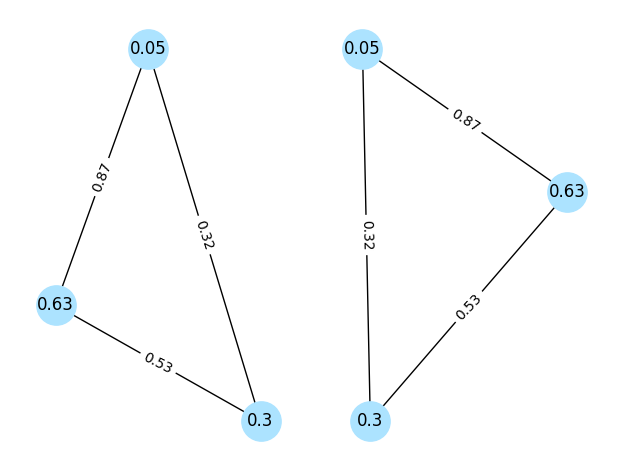

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# interpret diagonal of matrix as node attributes
node_labels = {n: A[n,n] for n in range(len(A))}
np.fill_diagonal(A, np.zeros(len(A)))

G1 = nx.Graph(A)
pos1=nx.spring_layout(G1)
nx.draw(G1, pos1, labels=node_labels, ax=ax1, node_size = 800, node_color = "#ACE3FF")
edge_labels = nx.get_edge_attributes(G1,'weight')
nx.draw_networkx_edge_labels(G1,pos1,edge_labels=edge_labels, ax=ax1)

# interpret diagonal of permuted matrix as node attributes
node_labels = {n: A_perm[n,n] for n in range(len(A_perm))}
np.fill_diagonal(A_perm, np.zeros(len(A)))

G2 = nx.Graph(A_perm)
pos2=nx.spring_layout(G2)
nx.draw(G2, pos2, labels=node_labels, ax=ax2, node_size = 800, node_color = "#ACE3FF")
edge_labels = nx.get_edge_attributes(G2,'weight')
nx.draw_networkx_edge_labels(G2,pos2,edge_labels=edge_labels, ax=ax2)

ax1.set_xlim([1.2*x for x in ax1.get_xlim()])
ax2.set_xlim([1.2*x for x in ax2.get_xlim()])
plt.tight_layout()
plt.show()

In [17]:
import pennylane as qml

def perm_equivariant_embedding(A, betas, gammas):
    """
    Ansatz to embedd a graph with node and edge weights into a quantum state.

    The adjacency matrix A contains the edge weights on the off-diagonal,
    as well as the node attributes on the diagonal.

    The embedding contains trainable weights 'betas' and 'gammas'.
    """
    n_nodes = len(A)
    n_layers = len(betas) # infer the number of layers from the parameters

    # initialise in the plus state
    for i in range(n_nodes):
        qml.Hadamard(i)

    for l in range(n_layers):

        for i in range(n_nodes):
            for j in range(i):
            	# factor of 2 due to definition of gate
                qml.IsingZZ(2*gammas[l]*A[i,j], wires=[i,j])

        for i in range(n_nodes):
            qml.RX(A[i,i]*betas[l], wires=i)

We can use this ansatz in a circuit.


In [18]:
n_qubits = 25
n_layers = 2

dev = qml.device("lightning.kokkos", wires=n_qubits)

@qml.qnode(dev)
def eqc(adjacency_matrix, observable, trainable_betas, trainable_gammas):
    """Circuit that uses the permutation equivariant embedding"""

    perm_equivariant_embedding(adjacency_matrix, trainable_betas, trainable_gammas)
    return qml.expval(observable)


A = create_data_point(n_qubits)
betas = np.random.rand(n_layers)
gammas = np.random.rand(n_layers)
observable = qml.PauliX(0) @ qml.PauliX(1) @ qml.PauliX(3)

qml.draw_mpl(eqc, decimals=2)(A, observable, betas, gammas)
plt.show()

Validating the equivariance
===========================

Let\'s now check if the circuit is really equivariant!

This is the expectation value we get using the original adjacency matrix
as an input:


In [19]:
result_A = eqc(A, observable, betas, gammas)
print("Model output for A:", result_A)

Model output for A: -4.893948459273658e-06


If we permute the adjacency matrix, this is what we get:


In [20]:
perm = [2, 3, 0, 1, 4]
A_perm = permute(A, perm)
result_Aperm = eqc(A_perm, observable, betas, gammas)
print("Model output for permutation of A: ", result_Aperm)

Model output for permutation of A:  0.37672998908782784


Why are the two values different? Well, we constructed an *equivariant*
ansatz, not an *invariant* one! Remember, an *invariant* ansatz means
that embedding a permutation of the adjacency matrix leads to the same
state as an embedding of the original matrix. An *equivariant* ansatz
embeds the permuted adjacency matrix into a state where the qubits are
permuted as well.

As a result, the final state before measurement is only the same if we
permute the qubits in the same manner that we permute the input
adjacency matrix. We could insert a permutation operator
`qml.Permute(perm)` to achieve this, or we simply permute the wires of
the observables!


In [21]:
observable_perm = qml.PauliX(perm[0]) @ qml.PauliX(perm[1]) @ qml.PauliX(perm[3])

Now everything should work out!


In [22]:
result_Aperm = eqc(A_perm, observable_perm, betas, gammas)
print("Model output for permutation of A, and with permuted observable: ", result_Aperm)

Model output for permutation of A, and with permuted observable:  0.07813512482425838


Et voilà!

Conclusion
==========

Equivariant graph embeddings can be combined with other equivariant
parts of a quantum machine learning pipeline (like measurements and the
cost function). [Skolik et al.
(2022)](https://arxiv.org/pdf/2205.06109.pdf), for example, use such a
pipeline as part of a reinforcement learning scheme that finds heuristic
solutions for the traveling salesman problem. Their simulations compare
a fully equivariant model to circuits that break permutation
equivariance and show that it performs better, confirming that if we
know about structure in our data, we should try to use this knowledge in
machine learning.

References
==========

1.  Andrea Skolik, Michele Cattelan, Sheir Yarkoni,Thomas Baeck and
    Vedran Dunjko (2022). Equivariant quantum circuits for learning on
    weighted graphs.
    [arXiv:2205.06109](https://arxiv.org/abs/2205.06109)
2.  Quynh T. Nguyen, Louis Schatzki, Paolo Braccia, Michael Ragone,
    Patrick J. Coles, Frédéric Sauvage, Martín Larocca and Marco Cerezo
    (2022). Theory for Equivariant Quantum Neural Networks.
    [arXiv:2210.08566](https://arxiv.org/abs/2210.08566)

About the author
================


In [23]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1701156630.432648
Tue Nov 28 07:30:30 2023
